In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/island-data-bottle-round-2/island-data-bottle-round-2/prices_round_2_day_0.csv', sep=';')

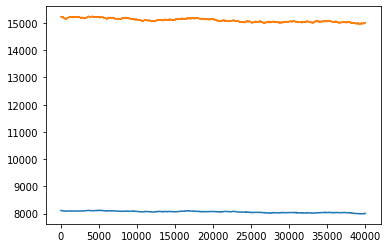

In [3]:
plt.plot(data[data['product'] == 'COCONUTS']['mid_price'])
plt.plot(data[data['product'] == 'PINA_COLADAS']['mid_price'])

In [14]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller

coco = data[data['product'] == 'COCONUTS']['mid_price']
pina = data[data['product'] == 'PINA_COLADAS']['mid_price']


model = sm.OLS(coco.to_numpy(), pina.to_numpy()).fit()
model.params[0]

0.5338352293479572

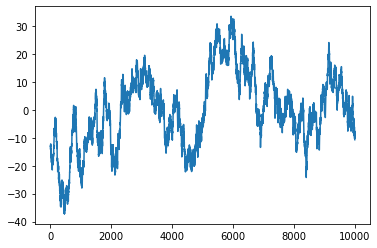

In [5]:
spread = coco.to_numpy() - model.params[0] * pina.to_numpy()
plt.plot(spread)

In [22]:
adf = adfuller(spread, maxlag=1)
print(adf[0])
print(adf[4])

-3.0521830758048245
{'1%': -3.431004228818807, '5%': -2.8618291302145686, '10%': -2.566923898875394}


In [19]:
def fit_ols(y, x):
    """Estimates long-run and short-run cointegration relationship for series y and x. 
    
    Uses a 2-step process to first estimate coefficients for the long-run relationship
        y_t = c + gamma * x_t + z_t
        
    and then the short-term relationship,
        y_t - y_(t-1) = alpha * z_(t-1) + epsilon_t,
        
    with z the found residuals of the first equation.
    
    Parameters
    ----------
    y : pd.Series
        The first time series of the pair to analyse.
    
    x : pd.Series
        The second time series of the pair to analyse.
    
    Returns
    -------
    c : float
        The constant term in the long-run relationship y_t = c + gamma * x_t + z_t. This 
        describes the static shift of y with respect to gamma * x.
        
    gamma : float
        The gamma term in the long-run relationship y_t = c + gamma * x_t + z_t. This
        describes the ratio between the const-shifted y and x.
        
    alpha : float
        The alpha term in the short-run relationship y_t - y_(t-1) = alpha * z_(t-1) + epsilon. This
        gives an indication of the strength of the error correction toward the long-run mean.
    
    z : pd.Series
        Series of residuals z_t from the long-run relationship y_t = c + gamma * x_t + z_t, representing
        the value of the error correction term. 
        
    """

    
    long_run_ols = OLS(y, add_constant(x), has_const=True)
    long_run_ols_fit = long_run_ols.fit()
    
    c, gamma = long_run_ols_fit.params
    z = long_run_ols_fit.resid

    short_run_ols = OLS(y.diff().iloc[1:], (z.shift().iloc[1:]))
    short_run_ols_fit = short_run_ols.fit()
    
    alpha = short_run_ols_fit.params[0]
        
    return c, gamma, alpha, z

def granger_cointegration_test(y, x):
    """Applies the two-step Engle & Granger test for cointegration. 
    
    First fits the long-run relationship
        y_t = c + gamma * x_t + z_t
    
    and then tests, by Dickey-Fuller phi=1 vs phi < 1 in
        z_t = phi * z_(t-1) + eta_t
        
    If this implies phi < 1, the z series is stationary is concluded to be
    stationary, and thus the series y and x are concluded to be cointegrated.
    Parameters
    ----------
    y : pd.Series
        the first time series of the pair to analyse
    
    x : pd.Series
        the second time series of the pair to analyse
        
    Returns
    -------
    dfstat : float
        The Dickey Fuller test-statistic for phi = 1 vs phi < 1 in the second equation. A more 
        negative value implies the existence of stronger cointegration.
    
    pvalue : float
        The p-value corresponding to the Dickey Fuller test-statistic. A lower value implies
        stronger rejection of no-cointegration, thus stronger evidence of cointegration.
        
    """
    
    #assert isinstance(y, pd.Series), 'Input series y should be of type pd.Series'
    #assert isinstance(x, pd.Series), 'Input series x should be of type pd.Series'
    #assert sum(y.isnull()) == 0, 'Input series y has nan-values. Unhandled case.'
    #assert sum(x.isnull()) == 0, 'Input series x has nan-values. Unhandled case.'
    #assert y.index.equals(x.index), 'The two input series y and x do not have the same index.'
    
    c, gamma, alpha, z = fit_ols(y, x)
    
    # NOTE: The p-value returned by the adfuller function assumes we do not estimate z first, but test 
    # stationarity of an unestimated series directly. This assumption should have limited effect for high N, 
    # so for the purposes of this course this p-value can be used for the EG-test. Critical values taking 
    # this into account more accurately are provided in e.g. McKinnon (1990) and Engle & Yoo (1987).
    
    adfstat, pvalue, usedlag, nobs, crit_values = adfuller(z, maxlag=1, autolag=None)
   
    return adfstat, pvalue

In [21]:
granger_cointegration_test(coco.to_numpy(), pina.to_numpy())

/home/filipe/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['has_const']
  warnings.warn(msg, ValueWarning)


AttributeError: 'numpy.ndarray' object has no attribute 'diff'